# AutoRegression Models from Statsmodels  

The univariate EDA notebook found a lag of one to present the best potential for an autoregression model.  Statsmodels has its AutoReg package that tidily prepares the data for us to fit a model.  

For timeseries plotting, autocorrelations and correlations consult the eda_input_prep.ipynb notebook.

## Autoregression as as Baseline  

Autoregression does exactly as it sounds:  it regresses a variable (target) on itself, but itself lagged by some value k.  The lag value chosen, k, is usually informed by a look at autocorrelations as was done in the EDA notebook.  This lag value is also known as the order of the autoregression.  

For the target variable, total_cases, a lag of one seemed like the best k value to reach for.  Comments on revisiting this value are made below, before the data input and modelling code begins.

### Stationarity:  
The AR model expects stationary data, meaning the mean and variance do not change over time, as discussed in the early data exploration.  This requirement is often not met, and there are tests that can be done to verify stationarity.

* When data have a trend, the autocorrelations for small lags tend to be large and positive because observations nearby in time are also nearby in size. So the ACF of trended time series tend to have positive values that slowly decrease as the lags increase.    
* When data are seasonal, the autocorrelations will be larger for the seasonal lags (at multiples of the seasonal frequency) than for other lags.    
* When data are both trended and seasonal, you see a combination of these effects.  

The above taken directly from Hyndman and Athanasopoulos' *Forecasting: Principles and Pratice* (2nd ed.)  https://otexts.com/fpp2/autocorrelation.html  

* The observations in a stationary time series are not dependent on time.  
* Time series are stationary if they do not have trend or seasonal effects. Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations.  
* When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary to be effective.  

The above taken directly from: https://machinelearningmastery.com/time-series-data-stationary-python/   

Should the data be found to be non-stationary, the data can be differenced.  Differencing is simply subtracting the last observed value from the current one, or:

y_diff = y(t) - y(t-1)

Sometimes data is log transformed to stabilize the variance.

The autocorrelation plots produced in the univariate EDA notebook do show some bigger swings further out if max_lags is set much higher than 50.  With that said, we're going to lean on the Augmented Dickey-Fuller test results to say our data is stationary.

The statsmodels AutoReg() model will be used for this first modelling trial.  
Docs:  https://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AutoReg.html 

Note:  an AR model is not necessarily an ideal choice.  It's a starting point, from which one can move onto MA (moving average), or ARMA (autoregressive moving average), ARIMA (autoregressive integrated moving average) models and so on.  The AR model is succinctly described below, and offers the ideal conditions to which it is suited:  no trend or seasonal components.  While the Augmenented Dickey-Fuller test indicated that the total_cases data was stationary, it is resonable to assume there must be some seasonality to the data - and this may be seen in the long-lagged autocorrelation plots - and it would therefore not be adequately fit with an AR model.  The timeseries plots of total_cases by year in the EDA notebook also suggested some seasonality, albeit less repeatable for Iquitos as it was for San Juan.

"The autoregression (AR) method predicts the subsequent value in a sequence using a linear combination of previous observations. 
The notation for the model involves specifying the order of the model p as a parameter to the AR function, e.g. AR(p). For example, AR(1) is a first-order autoregression model.
The method is best suited for single-variable time series that lack trend and seasonal components."

Reference:  https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

> Note on autocorrelation vs partial autocorrelation to support order selection:
>
>In further modelling efforts using other algorithms, adding the features, and considering longer time lags given the inclusion of features, there's been an observation that the lagged target variable may yet provide useful information at lags greater than 1.  Carrying out analyses to choose an optimal lag value to enter in an autoregressive model is called order selection.  There is a "select order" function from Statsmodels that can assist in finding the optimal order.  The EDA notebook looked at a simple autocorrelation of the target with respect to its lagged self, but another tool to consider is partial autocorrelations.  Partial autocorrelations account for the target's relationship to any given input, at a particular lag/order, while taking into account that target and that input's relationship to the other inputs.  This requires investigation, and has not been used in this project.
> 
> For some background reading:  https://online.stat.psu.edu/stat510/lesson/2/2.2   
>
> For plotting PACFs:  https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html  
>
>The optimal lags (orders) found in the EDA notebook are still a useful exercise as they can prompt a more careful review of the data, but it is good to know that we can leverage a package to confirm or question what was found in the more manual EDA effort.  
>https://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.ar_select_order.html  

In [92]:
import sys
import os
print("Before anything is modified here are the system path and the current working directory:")
print(sys.path)
print(os.getcwd())
os.chdir('C:\\Users\\ron_d\\lhl_capstone\\multivariate_timeseries_forecasting_dengue')
sys.path.append('C:\\Users\\ron_d\\lhl_capstone\\multivariate_timeseries_forecasting_dengue\\src')
print("\nNow that things have been modified, here are the system path and the current working directory:")
print(sys.path)
print(os.getcwd())

Before anything is modified here are the system path and the current working directory:
['c:\\Users\\ron_d\\lhl_capstone\\multivariate_timeseries_forecasting_dengue\\notebooks', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds\\python310.zip', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds\\DLLs', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds\\lib', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds', '', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds\\lib\\site-packages', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds\\lib\\site-packages\\win32', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds\\lib\\site-packages\\win32\\lib', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds\\lib\\site-packages\\Pythonwin', 'C:\\Users\\ron_d\\lhl_capstone\\multivariate_timeseries_forecasting_dengue\\src', 'C:\\Users\\ron_d\\lhl_capstone\\multivariate_timeseries_forecasting_dengue\\src']
C:\Users\ron_d\lhl_capstone\multivariate_timeseries_forecasting_dengue

Now that things have been modified, here are the system path and the current working

In [93]:
import os
import pandas as pd
from pandas import read_csv
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns 
#import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from pandas import concat
from timeseries_data_prep import train_test_split_rows_reserved

### Data Import and Preparation  

The CSV files read in are generated from the eda_input_prep.ipynb notebook.

In [94]:
# Get the absolute path to the project directory
project_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Adjust the path to your data file
data_file_path = os.path.join(project_dir, 'multivariate_timeseries_forecasting_dengue', 'data', 'sj_df.csv')

# Read the CSV using the relative path
sj_df = pd.read_csv(data_file_path, header=0, index_col=0)

# For input to train_test_split_rows_reserved
values = sj_df.values # not required for series_to_supervised as done for other model algorithms; testing w/o it for train_test_split

# Set print options to display more rows and columns
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

The below could also benefit from simply using train_test_split_rows_reserved.  Streamlining opportunity.

In [95]:
test_frac = 0.30

# total_rows = sj_df.shape[0]
# train_rows = int(total_rows * (1-test_frac))
# test_rows = total_rows - train_rows

# print(f"Total size of the set is: {sj_df.shape[0]}")
# print(f"San Juan training set size: {train_rows} rows")
# print(f"San Juan testing set size: {test_rows} rows")

# Create the training and testing sets
# sj_df_train = sj_df.iloc[:train_rows]
# sj_df_test = sj_df.iloc[train_rows:]

#streamlining test,using same df names as below for now to see if it even works
# only works if I feed it values (which can be generated above in "Data Import and preparation")
# OR I use .iloc inside the train_test_split_rows_reserved
sj_df_train, sj_df_test = train_test_split_rows_reserved(values,int(test_frac*sj_df.shape[0]))
print(f"Dataset length: {sj_df.shape[0]}")
print(f"Training set length: {len(sj_df_train)}")
print(f"Testing set length: {len(sj_df_test)}")

Dataset length: 936
Training set length: 656
Testing set length: 280


Uncomment the below to work on Iquitos' dataset.

In [101]:
# total_rows = iq_df.shape[0]
# train_rows = int(total_rows * 0.70)
# test_rows = total_rows - train_rows

# print(f"Iquitos training set size: {train_rows} rows")
# print(f"Iquitos testing set size: {test_rows} rows")

# # Create the training and testing sets
# iq_df_train = iq_df.iloc[:train_rows]
# iq_df_test = iq_df.iloc[train_rows:]

### Fit the AR model to the training labels   

We'll start by modelling San Juan's data, and we'll start with lag 1.

In [102]:
model_sj_lag1 = AutoReg(sj_df_train[ : ,0], lags=1) # the lag chosen earlier
model_sj_fit_lag1 = model_sj_lag1.fit()
coef = model_sj_fit_lag1.params
print(coef)
print(model_sj_fit_lag1.summary())

[1.32290887 0.96668699]
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  656
Model:                     AutoReg(1)   Log Likelihood               -2696.338
Method:               Conditional MLE   S.D. of innovations             14.844
Date:                Tue, 20 Feb 2024   AIC                           5398.676
Time:                        21:42:04   BIC                           5412.130
Sample:                             1   HQIC                          5403.893
                                  656                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3229      0.703      1.883      0.060      -0.054       2.700
y.L1           0.9667      0.010     96.680      0.000       0.947       0.986
                            

The first parameter returned, labelled "const" is the intercept, while the 2nd parameter returned, labelled "total_cases.L1" is the slope applied to each target at time t-1 (lag 1) in order to predict the target at time t:

target(t) = intercept + slope * target(t-1)

Let's see how well it predicts the training labels using this model, and then we'll see about the predictions on the test labels.  

#### Trying the Order Selector  

This will find the optimal lag for us rather than us setting it to 1, as above.  The autocorrelation plots from the EDA notebook suggested it could be as high as 10 or so.  We'll have it search out to 14.

The order selector settles on a lag of 5.  Though if I'm interpreting the p values correctly, lag 2 might be one to drop.  I'll leave it in for now.

Let's see what this does to our predictions/forecasts.

In [103]:
selector = ar_select_order(sj_df_train[ : , 0], 15)
model_sj_lagopt = AutoReg(sj_df_train[ : , 0], lags=selector.ar_lags) # the lag chosen earlier
model_sj_fit_lagopt = model_sj_lagopt.fit()
coef_lagopt = model_sj_fit_lagopt.params
print(coef_lagopt)
print(model_sj_fit_lagopt.summary())

[ 2.00452725  1.14987288 -0.11245148 -0.12017172  0.18550627 -0.15307638]
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  656
Model:                     AutoReg(5)   Log Likelihood               -2656.887
Method:               Conditional MLE   S.D. of innovations             14.329
Date:                Tue, 20 Feb 2024   AIC                           5327.774
Time:                        21:42:04   BIC                           5359.124
Sample:                             5   HQIC                          5339.933
                                  656                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0045      0.692      2.895      0.004       0.648       3.362
y.L1           1.1499      0.039     29.689      0.000   

### Generate Predictions on the Training Data  

Docs:  https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.AutoRegResults.html  

`.predict()` gets you:  In-sample prediction and out-of-sample forecasting  
`.get_prediction()` gets you:  Predictions and prediction intervals  
`.forecast()` gets you:  Out-of-sample forecasts  

Scratching your head yet?  So were others:  https://stats.stackexchange.com/questions/479645/difference-between-forecasting-and-predicting-in-statsmodels-sarimax  

Ok, that's for SARIMAX, but I think the idea translates.

"What the documentation seems to say is that the only difference is that "forecast" is ONLY for predictions at the end of the data (out of sample), whereas "predict" returns predictions from any origin (either from within the sample, or at the end of it). "

I'm grappling with that.  But this sounds interesting:  

`.apply()`:  Apply the fitted parameters to new data unrelated to the original data

We're using the length of the test set so we can take those predictions and compare to test and get some metrics.

#### Lag 1 Model Predictions/Forecasts  

The below was informed by the code proposed here under the header Autoregression Model:  
https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/  

You effectively produce one forecast that's however many time periods out (weeks, in this dataset's case) from the end of your training set.  The length of the forecast is the length of your test set, as defined in your train-test splitting approach.

> Note:  I think something was lost - the original index pre-train_test_split - when the dataset (whose values were extracted using `.values()` was used) was split into training and testing sets, such that the below can no longer recognize when the training set ends and the testing set begins.  So where I used to call for a plot of the training set, followed by the testing set, with the prediction overlaid, it complains of indices that are out of bounds.  I now just display the testing set and predictions.  

> Kept getting IndexError: index 656 is out of bounds for axis 0 with size 280

The below was for the lag 1 model.  We'll later see what it looks like for the auto-selected lag of 5.

Trying to make the new format work where the df's are numpy arrays (from using train_test_split_rows_reserved on .values)

In [105]:
# original: before the use of train_test_split_rows_reserved on values

# predictions_lag1 = model_sj_fit_lag1.predict(start=len(sj_df_train['total_cases']), end=len(sj_df_train['total_cases'])+len(sj_df_test)-1, dynamic=False)
# for i in range(len(predictions_lag1)):
#  print('predicted=%f, expected=%f' % (predictions_lag1[len(sj_df_train['total_cases'])+i], sj_df_test['total_cases'].iloc[i]))
# rmse = sqrt(mean_squared_error(sj_df_test['total_cases'], predictions_lag1))
# mae = mean_absolute_error(sj_df_test['total_cases'], predictions_lag1)
# print('Lag 1 Test Predictions RMSE: %.3f' % rmse)
# print('Lag 1 Test Predictions MAE: %.3f' % mae)

# plt.plot(sj_df_train['total_cases'])
# plt.plot(predictions_lag1, color='red') 
# plt.plot(sj_df_test['total_cases'], color='green')
# plt.title('San Juan Dengue Cases with Predictions')
# plt.show()

predicted=6.156344, expected=9.000000
predicted=7.274166, expected=3.000000
predicted=8.354751, expected=6.000000
predicted=9.399338, expected=11.000000
predicted=10.409126, expected=7.000000
predicted=11.385276, expected=7.000000
predicted=12.328907, expected=15.000000
predicted=13.241103, expected=9.000000
predicted=14.122911, expected=6.000000
predicted=14.975343, expected=6.000000
predicted=15.799378, expected=6.000000
predicted=16.595962, expected=7.000000
predicted=17.366010, expected=10.000000
predicted=18.110404, expected=8.000000
predicted=18.830001, expected=7.000000
predicted=19.525626, expected=12.000000
predicted=20.198077, expected=3.000000
predicted=20.848128, expected=2.000000
predicted=21.476523, expected=7.000000
predicted=22.083984, expected=5.000000
predicted=22.671209, expected=5.000000
predicted=23.238871, expected=7.000000
predicted=23.787624, expected=7.000000
predicted=24.318095, expected=7.000000
predicted=24.830895, expected=7.000000
predicted=25.326612, expe

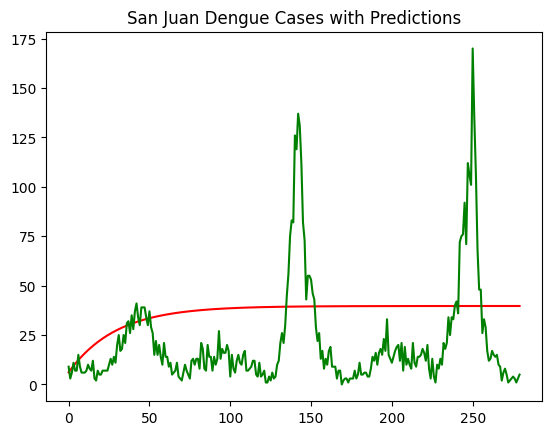

In [106]:
# You get "IndexError: index 656 is out of bounds for axis 0 with size 280" if you use the commented out print line
predictions_lag1 = model_sj_fit_lag1.predict(start=len(sj_df_train), end=len(sj_df_train)+len(sj_df_test)-1, dynamic=False)
for i in range(len(predictions_lag1)):
 print('predicted=%f, expected=%f' % (predictions_lag1[i], sj_df_test[ i , 0]))
 # print('predicted=%f, expected=%f' % (predictions_lag1[len(sj_df_train)+i], sj_df_test[ i , 0])) # did not like this
rmse = sqrt(mean_squared_error(sj_df_test[ : , 0], predictions_lag1))
mae = mean_absolute_error(sj_df_test[ : , 0], predictions_lag1)
print('Lag 1 Test Predictions RMSE: %.3f' % rmse)
print('Lag 1 Test Predictions MAE: %.3f' % mae)

#plt.plot(sj_df_train[ : , 0])
plt.plot(predictions_lag1, color='red') 
plt.plot(sj_df_test[ : , 0], color='green')
plt.title('San Juan Dengue Cases with Predictions')
plt.show()

This is basically applying the slope and intercept to the last known (training) value and then applying these same parameters onto the last point - the prediction - for the length requested in the function, resulting in a prediction curve that settles out.

Below we try the forecast function.  It produces the exact same results as the predict function.

predicted=6.156344, expected=9.000000
predicted=7.274166, expected=3.000000
predicted=8.354751, expected=6.000000
predicted=9.399338, expected=11.000000
predicted=10.409126, expected=7.000000
predicted=11.385276, expected=7.000000
predicted=12.328907, expected=15.000000
predicted=13.241103, expected=9.000000
predicted=14.122911, expected=6.000000
predicted=14.975343, expected=6.000000
predicted=15.799378, expected=6.000000
predicted=16.595962, expected=7.000000
predicted=17.366010, expected=10.000000
predicted=18.110404, expected=8.000000
predicted=18.830001, expected=7.000000
predicted=19.525626, expected=12.000000
predicted=20.198077, expected=3.000000
predicted=20.848128, expected=2.000000
predicted=21.476523, expected=7.000000
predicted=22.083984, expected=5.000000
predicted=22.671209, expected=5.000000
predicted=23.238871, expected=7.000000
predicted=23.787624, expected=7.000000
predicted=24.318095, expected=7.000000
predicted=24.830895, expected=7.000000
predicted=25.326612, expe

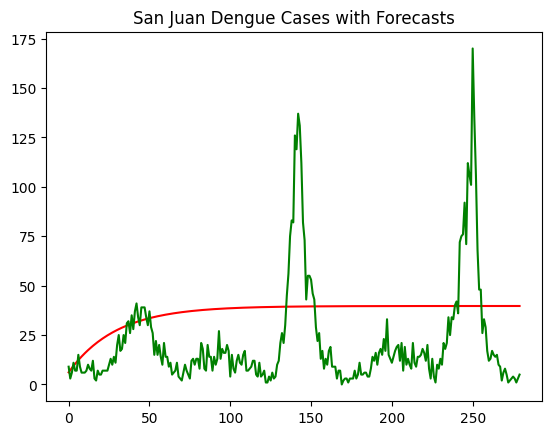

In [107]:
# You get "IndexError: index 656 is out of bounds for axis 0 with size 280" if you use the commented out print line
forecast_lag1 = model_sj_fit_lag1.forecast(steps=len(sj_df_test))
for i in range(len(forecast_lag1)):
 print('predicted=%f, expected=%f' % (forecast_lag1[i], sj_df_test[ i , 0]))
 # print('predicted=%f, expected=%f' % (predictions_lag1[len(sj_df_train)+i], sj_df_test[ i , 0])) # did not like this
rmse = sqrt(mean_squared_error(sj_df_test[ : , 0], forecast_lag1))
mae = mean_absolute_error(sj_df_test[ : , 0], forecast_lag1)
print('Lag 1 Test Predictions RMSE: %.3f' % rmse)
print('Lag 1 Test Predictions MAE: %.3f' % mae)

#plt.plot(sj_df_train[ : , 0])
plt.plot(forecast_lag1, color='red') 
plt.plot(sj_df_test[ : , 0], color='green')
plt.title('San Juan Dengue Cases with Forecasts')
plt.show()

In [108]:
len(predictions_lag1)

280

In [109]:
# original before use of train_test_split_rows_reserved on values

# forecast = model_sj_fit_lag1.forecast(steps=len(sj_df_test))
# for i in range(len(forecast)):
#  print('predicted=%f, expected=%f' % (forecast[len(sj_df_train['total_cases'])+i], sj_df_test['total_cases'].iloc[i]))
# rmse = sqrt(mean_squared_error(sj_df_test['total_cases'], forecast))
# mae = mean_absolute_error(sj_df_test['total_cases'], forecast)
# print('Test RMSE: %.3f' % rmse)
# print('Test MAE: %.3f' % mae)
      
# plt.plot(sj_df_train['total_cases'])
# plt.plot(forecast, color='red') 
# plt.plot(sj_df_test['total_cases'], color='green')
# plt.title('San Juan Dengue Cases with Forecasts')
# plt.show()

#### Lag 5 Model Predictions/Forecasts  

Now let's produce predictions, errors and plots for the auto-selected lag 5 model.  

The plot on the prediction just rises more sharply than for lag 1.

predicted=7.963727, expected=9.000000
predicted=9.121730, expected=3.000000
predicted=11.006039, expected=6.000000
predicted=12.839455, expected=11.000000
predicted=15.146389, expected=7.000000
predicted=17.127598, expected=7.000000
predicted=19.098283, expected=15.000000
predicted=20.915968, expected=9.000000
predicted=22.693682, expected=6.000000
predicted=24.310994, expected=6.000000
predicted=25.814654, expected=6.000000
predicted=27.183700, expected=7.000000
predicted=28.446016, expected=10.000000
predicted=29.590766, expected=8.000000
predicted=30.631980, expected=7.000000
predicted=31.572611, expected=12.000000
predicted=32.424164, expected=3.000000
predicted=33.191569, expected=2.000000
predicted=33.883109, expected=7.000000
predicted=34.504772, expected=5.000000
predicted=35.063600, expected=5.000000
predicted=35.565176, expected=7.000000
predicted=36.015192, expected=7.000000
predicted=36.418558, expected=7.000000
predicted=36.780001, expected=7.000000
predicted=37.103679, ex

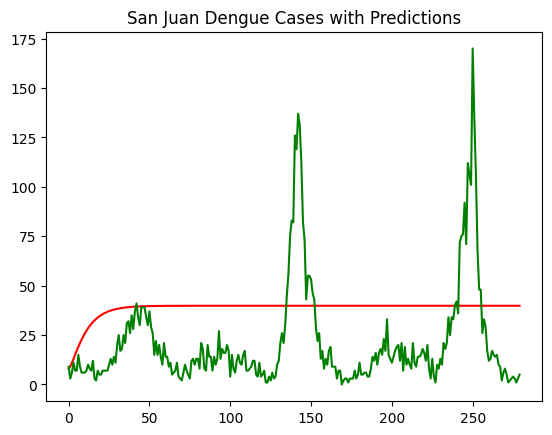

In [110]:
predictions_lagopt = model_sj_fit_lagopt.predict(start=len(sj_df_train), end=len(sj_df_train)+len(sj_df_test)-1, dynamic=False)
for i in range(len(predictions_lagopt)):
 print('predicted=%f, expected=%f' % (predictions_lagopt[i], sj_df_test[ i , 0]))
rmse = sqrt(mean_squared_error(sj_df_test[ : , 0], predictions_lagopt))
mae = mean_absolute_error(sj_df_test[ : , 0], predictions_lagopt)
print('Optimized Lag Test Predictions RMSE: %.3f' % rmse)
print('Optimized Lag Test Predictions MAE: %.3f' % mae)

#plt.plot(sj_df_train[ : , 0])
plt.plot(predictions_lagopt, color='red') 
plt.plot(sj_df_test[ : , 0], color='green')
plt.title('San Juan Dengue Cases with Predictions')
plt.show()

In [111]:
# predictions_lagopt = model_sj_fit_lagopt.predict(start=len(sj_df_train['total_cases']), end=len(sj_df_train['total_cases'])+len(sj_df_test)-1, dynamic=False)
# for i in range(len(predictions_lagopt)):
#  print('predicted=%f, expected=%f' % (predictions_lagopt[len(sj_df_train['total_cases'])+i], sj_df_test['total_cases'].iloc[i]))
# rmse = sqrt(mean_squared_error(sj_df_test['total_cases'], predictions_lagopt))
# mae = mean_absolute_error(sj_df_test['total_cases'], predictions_lagopt)
# print('Optimized Lag Test Predictions RMSE: %.3f' % rmse)
# print('Optimized Lag Test Predictions MAE: %.3f' % mae)

# plt.plot(sj_df_train['total_cases'])
# plt.plot(predictions_lagopt, color='red') 
# plt.plot(sj_df_test['total_cases'], color='green')
# plt.title('San Juan Dengue Cases with Predictions')
# plt.show()

### Using the Model Coefficients to Walk the Predictions Forward  

The below taken from machine learning mastery: https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/  

(He trained a model with a lag=29)

"The statsmodels API does not make it easy to update the model as new observations become available.

One way would be to re-train the AutoReg model each day as new observations become available, and that may be a valid approach, if not computationally expensive.

**An alternative would be to use the learned coefficients and manually make predictions. This requires that the history of 29 prior observations be kept and that the coefficients be retrieved from the model and used in the regression equation to come up with new forecasts.** (this is what's done below, but as we're using 1 lag, we're keeping 1 prior observation, or training set point)

The coefficients are provided in an array with the intercept term followed by the coefficients for each lag variable starting at t-1 to t-n. We simply need to use them in the right order on the history of observations, as follows:

yhat = b0 + b1*X1 + b2*X2 ... bn*Xn"

The below is done with the lag 1 model.

predicted=6.156344, expected=9.000000
predicted=10.023092, expected=3.000000
predicted=4.222970, expected=6.000000
predicted=7.123031, expected=11.000000
predicted=11.956466, expected=7.000000
predicted=8.089718, expected=7.000000
predicted=8.089718, expected=15.000000
predicted=15.823214, expected=9.000000
predicted=10.023092, expected=6.000000
predicted=7.123031, expected=6.000000
predicted=7.123031, expected=6.000000
predicted=7.123031, expected=7.000000
predicted=8.089718, expected=10.000000
predicted=10.989779, expected=8.000000
predicted=9.056405, expected=7.000000
predicted=8.089718, expected=12.000000
predicted=12.923153, expected=3.000000
predicted=4.222970, expected=2.000000
predicted=3.256283, expected=7.000000
predicted=8.089718, expected=5.000000
predicted=6.156344, expected=5.000000
predicted=6.156344, expected=7.000000
predicted=8.089718, expected=7.000000
predicted=8.089718, expected=7.000000
predicted=8.089718, expected=7.000000
predicted=8.089718, expected=10.000000
p

C:\Users\ron_d\AppData\Local\Temp\ipykernel_21960\994259581.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('predicted=%f, expected=%f' % (yhat, obs))


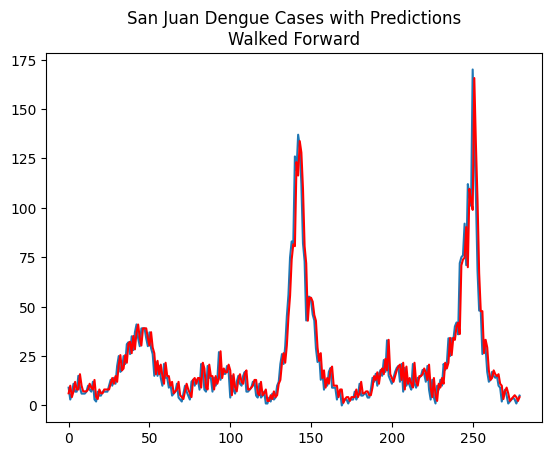

In [112]:
# massage my dataset into the format required below

#train_sj = sj_df_train['total_cases'].values
train_sj = sj_df_train[ : , 0].reshape(-1, 1)
#print(train_sj)

#test_sj = sj_df_test['total_cases'].values
test_sj = sj_df_test[ : , 0].reshape(-1, 1)

window = 1 # the "run-up" required for your model to produce a prediction per the number of lags used for your AR model, per the autocorrelation findings.  I used 1 lag.

# walk forward over time steps in test

# Overall, for a lag value of 1: 
# for the length of the test set (see t), it...
# ROUND 1 (t): starts on the last value of the training set (entered in history), multiplies it by the coefficient returned by the model training (fit), adds the intercept returned by the model,
# and then appends the prediction to a predictions list AND assigns the first value in the test set to obs (observed/seen value) AND appends this value to the history (now length 2),
# it now has two lists aligned on index with a test value (observed) and prediction value, so it can later to error calculations and plots.
# ROUND 2 (t): it now starts on the history value that was just appended, which is the first test (obs) value and multiplies it by the coefficient and adds the intercept to produce the next predicted
# value, appends that to the predictions list, appends the 2nd test set value to the history (now length 3), and so on until it reaches the end of the length count on the test set.
# There's no model re-fitting happening, unlike the walk-forward validation with the random forest forecast.


# Subtracts lag (window) from length of training set. For example's sake, say len(train) = 700. It's train_sj[699] onward in the train_sj array.
history = train_sj[len(train_sj)-window: ]                  
# but if train_sj goes from 0 to 699, and history is train_sj[699: ], then it's 1 row long. That's it.
#print(history)                                             # history is 1 item long if your lag is 1 as it is in this case

history = [history[i] for i in range(len(history))]         # len(history) is 1 for lag 1, so starts & ends at history[0]. Produces list of arrays: total_cases in train_sj, train_sj[699] for lag 1.
predictions = list()                                        # initialize an empty predictions list
for t in range(len(test_sj)):                               # for t 0 to the end of the span of the test set (~281 as I recall)
    length = len(history)                                   # len(history) is 1 at lag 1 AND FOR ROUND 1:  as soon as the test obs is appended to history a few lines down, history grows
    lag = [history[i] for i in range(length-window,length)] # range(1-1, 1), so 0 to 1. lag=history[0] as range is endpt exclusive.  Basically it's train_sj[699]
    yhat = coef[0]                                          # lag becomes history[1] on ROUND 2 because history grew by one value (last test_sj/obs) so range(2-1,2), or range(1,2), and history[1] is that first test value/obs
    for d in range(window):                                 # in our case: for 0 to 1, 1 being excluded by range
        yhat += coef[d+1] * lag[window-d-1]                 # I think this works w/o indenting the next lines into the 2nd for: if you have lag 2, you want the coeff(@lag_number) * train_sj (on ROUND 1 IF lag 1; otherwise it's obs/seen test value) value associated with that lag
    obs = test_sj[t]                                        # (see how AutoReg produces coefficients at lags > 1 for verification of alignment)
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

rmse = sqrt(mean_squared_error(test_sj, predictions))
print('Test RMSE: %.3f' % rmse)
mae = mean_absolute_error(test_sj, predictions)
print('Test MAE: %.3f' % mae)
# plot
plt.plot(test_sj)
plt.plot(predictions, color='red')
plt.title('San Juan Dengue Cases with Predictions\nWalked Forward')
plt.show()


In the `.predict()` and `.forecast()`, it never gets the test set as input, it only gets a length.  The walk-forward done above applies the coefficient and intercept to EACH test point.

In [113]:
history

[array([5.]),
 array([9.]),
 array([3.]),
 array([6.]),
 array([11.]),
 array([7.]),
 array([7.]),
 array([15.]),
 array([9.]),
 array([6.]),
 array([6.]),
 array([6.]),
 array([7.]),
 array([10.]),
 array([8.]),
 array([7.]),
 array([12.]),
 array([3.]),
 array([2.]),
 array([7.]),
 array([5.]),
 array([5.]),
 array([7.]),
 array([7.]),
 array([7.]),
 array([7.]),
 array([10.]),
 array([13.]),
 array([10.]),
 array([14.]),
 array([11.]),
 array([20.]),
 array([25.]),
 array([17.]),
 array([18.]),
 array([25.]),
 array([21.]),
 array([31.]),
 array([32.]),
 array([26.]),
 array([35.]),
 array([28.]),
 array([37.]),
 array([41.]),
 array([34.]),
 array([30.]),
 array([39.]),
 array([39.]),
 array([39.]),
 array([34.]),
 array([30.]),
 array([37.]),
 array([29.]),
 array([26.]),
 array([15.]),
 array([22.]),
 array([15.]),
 array([20.]),
 array([14.]),
 array([10.]),
 array([21.]),
 array([14.]),
 array([14.]),
 array([9.]),
 array([11.]),
 array([5.]),
 array([6.]),
 array([7.]),
 array

In [114]:
history[0]

array([5.])

In [115]:
# has the last training set point and adds the entirety of the test set in the walk-forward function
len(history)

281